In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, date
import os
import re
import json
import math
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from functools import reduce

os.chdir('../Tools/libs/')
import text_mining_lib as tmlib
os.chdir('../vk_upload/')
import vk_api
os.chdir('../../BrandSocmediaDashboard/')

%matplotlib inline
pd.set_option('mode.chained_assignment', None)

In [2]:
brand_list = ['MMX', 'Agusha', 'Adrenaline', 'LADA', 'Retail', 'Alfabank', 'Daimler']

In [3]:
taxonomy = pd.read_csv('../DATA/Taxonomy/Custom_Taxonomy_Vk.csv', encoding='cp1251', sep=';', header=0, index_col=(0, 1))

In [25]:
add_part = False
today = str(date.today())
chunk = 20000

for brand in ['Adrenaline']:
    brand = brand.lower()
    filename = f'youscan_{brand}_total'
    
    #загрузка параметров    
    with open(f'modeling/{brand}_config.json', 'r') as f:
        configs = json.load(f)

    print('загрузка данных')
    files = os.listdir('../DATA/BrandSocmediaDashboard/processed/')
    #Если мы строим датасет в первый раз и хотим обработать все, что есть
    if not add_part:
        #Может, мы еще не сохраняли предобработанный датасет
        if f'{filename}-processed.csv' not in files:
            print('Запуск предобработки')
            df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/{filename}.csv', sep=';')
#             df = df.sample(frac=0.05)
            df = tmlib.first_process(df)
            df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions'])   
            df = tmlib.cross_posting_remove(df)
            df = df.applymap(tmlib.replace_semicolon)
            df.to_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed.csv', index=False, sep=';')
        #Если же все уже обработано, то просто загружаем
        else:
            df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed_cleaned.csv', sep=';')
#             df = df.sample(min([5000, len(df)]))
#             df = df.sample(frac=0.1)
            df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions']) 
            df = df.applymap(tmlib.replace_semicolon)
    #Но может мы хотим обработать только часть
    else:
        #Тогда загрузим необработанный полный датасет
        df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/{filename}.csv')
        #поищем обработанный датасет в папке out 
        #(это значит, что у нас датасеты как минимум один раз дублируется, 
        #ну что ж, значит такая судьба, но вообще подумать)
        files_out = [f for f in os.listdir(f'DATA/') if f'dashboard-table_bsd_{brand}_youscan' in f]
        #Если такие файлы есть, то выберем последний
        if len(files_out)>0:
            old_ids = list(pd.read_csv('DATA/'+sorted(files_out)[-1])['postId'].unique())
            #И возьмем только записи, которые мы еще не обрабатывали
            df = df[~df['postId'].isin(old_ids)]
        df = tmlib.first_process(df, f'{filename}_part-{today}')
        df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions'])   
        df = tmlib.cross_posting_remove(df)

    init_columns = df.columns   
    #создание тематик
    total_df = []
    post_ids = {}
    print('тематики')
    for category in list(configs['brand_dict'].keys()):
        print('    ', category)
        cat_df = []        
        for k in tqdm(range(math.ceil(len(df)/chunk))):
    
            cat_df_k = tmlib.build_topics(df.iloc[chunk*k:chunk*(k+1), :], category,\
                            (configs['theme_stopwords'], configs['brand_dict']), \
                            separ_brands=True, params=configs['params'][category],\
                            power=configs['power'], names_dict=configs['names_dict'], 
                            #category_tokens=configs['category_tokens'],\
                            sentiment_list=list(configs['names_dict'][category].keys()))
            cat_df.append(cat_df_k)
            post_ids[k] = cat_df_k['postId'].to_list()
        cat_df = pd.concat(cat_df, ignore_index=True, sort=False)
        total_df.append(cat_df)
    total_df = pd.concat(total_df,ignore_index=True, sort=False) 
    
    df = []
    
#     загрузим информацию о пользователях вк и посчитаем их таксономическое описание
    try:
        total_df['vk_id'] = total_df['vk_id'].replace({'': 0})
    except:
        pass
    total_df['vk_id'] = total_df['vk_id'].fillna(0).astype(int).astype(str).replace({'0': ''})
    ids = list(total_df['vk_id'].dropna().astype(str).unique())
    try:
        ids.remove('')
    except:
        pass
    folder = '../DATA/BrandSocmediaDashboard/processed/'

    files = os.listdir(folder)
    users_df_name = f'vkapi_{brand}_users-df.csv'
    groups_df_name = f'vkapi_{brand}_groups-df.csv'

    users_df = pd.read_csv(folder+users_df_name) if (users_df_name in files) else False
    groups_df = pd.read_csv(folder+groups_df_name) if (groups_df_name in files) else False    

    #если появились новые id, для которых нет описания, загрузим только их
    print('загрузка недостающих данных по vk api')
    users_df, groups_df = tmlib.upload_new_ids(ids, users_df, groups_df)

    users_df.to_csv(folder+users_df_name, index=False)
    groups_df.to_csv(folder+groups_df_name, index=False)

    users_df['vk_id'] = users_df['vk_id'].astype(int).astype(str)
    groups_df['vk_id'] = groups_df['vk_id'].astype(int).astype(str)
    groups_df = groups_df[groups_df['group_id']!='']

    total_df['vk_id'] = total_df['vk_id'].replace({'': '0'}).fillna(0).astype(int).astype(str).replace({'0': ''})
    print('таксономия')
    #а тут присоединяется таксономическое описание
    files = os.listdir('../DATA/BrandSocmediaDashboard/processed/')
    #Для начала посмотрим, есть ли файлик с уже обсчитанной таксономией
    if f'{filename}-taxonomy.csv' not in files:
        print('считаем с нуля')
        #если нет, тогда просто посчитаем
        total_df = tmlib.taxonomy_concat((users_df, groups_df), total_df) 
        #и сохраним
        taxonomy_columns = [col for col in total_df.columns if ('('==col[0])and(')'==col[-1])]
        total_df[['vk_id']+taxonomy_columns].drop_duplicates(
            subset=['vk_id']).to_csv(
            f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv', index=False)
    else:
        print('уже есть, загружаем')
        #если есть, то загрузим его
        df_tax = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv').dropna()
        df_tax['vk_id'] = df_tax['vk_id'].astype(int).astype(str)
        tax_ids = list(df_tax['vk_id'].unique())
        try:
            tax_ids.remove('0')
        except:
            pass
        #И посмотрим, для всех ли пользователей вычислено таксономическое описание
        if set(total_df['vk_id'].unique()).issubset(set(tax_ids)):
            print('уже все посчитано, присоединяем')
            #если да, то просто приединим
            total_df = total_df.merge(df_tax, on='vk_id', how='left')
        else:  
            print('чего-то не хватает, досчитаем')
            #если нет, то вычислим недостающие
            part_df = total_df[~total_df['vk_id'].isin(tax_ids)].copy()
            part_df = tmlib.taxonomy_concat((users_df[~users_df['vk_id'].isin(tax_ids)], groups_df[~groups_df['vk_id'].isin(tax_ids)]), part_df) 
            #И сохраним итоговый файл
        taxonomy_columns = [col for col in part_df.columns if '('==col[0] and ')'==col[-1]]
        df_tax = pd.concat([df_tax, part_df[['vk_id']+taxonomy_columns].drop_duplicates(subset=['vk_id'])], sort=False)
        df_tax.to_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv', index=False)
        total_df = total_df.merge(df_tax, on='vk_id', how='left')
    
    print('кластеры')
    cluster_list = []
    for k in tqdm(range(math.ceil(len(total_df)/chunk))):

        cl_df = tmlib.create_tax_clusters(total_df.iloc[chunk*k:chunk*(k+1)])
        cl_df = tmlib.rename_clusters(cl_df, configs['segments_dict'])
        cluster_list.append(cl_df)
    total_df = pd.concat(cluster_list, sort=False)

    print('группы топиков')
    total_df = tmlib.segment_choice(total_df, 0.2)

    total_df = total_df.reset_index(drop=True)
    total_df['unique_id'] = total_df.index.to_series()
    
    print('схлопываем бинарные столбцы')
    tax_columns = [col for col in total_df.columns if '('==col[0] and ')'==col[-1]]
    brand_columns = [col for col in total_df.columns if '_brand' in col]
    
    total_df['taxonomy_attr'] = total_df[tax_columns].apply(lambda x: ', '.join([col for i, col in enumerate(tax_columns) if  x[i]==1]), axis=1)
    total_df = total_df.drop(columns=tax_columns+brand_columns) 
    total_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_total_{today}.csv', index=False, sep=';')
    
    eng_cols = [col for col in total_df.columns if 'engagement' in col]
    topic_columns = [col for col in total_df.columns if 'topic' in col]
    
    youscan_columns = ['unique_id', "author.gender", "author.age", "author.subscribers", "author.url", "autoCategories", "postType", "city",  "fullText", "id", "publicationPlace.name", "publicationPlace.subscribers", "publicationPlace.url", "region", "sentiment", "source", "seq", "url", "vk_id", "unique_id","postId","published"] + eng_cols    
    modeled_columns = ['unique_id', 'Category', 'brands', 'clusters', 'group_of_topics_0',
       'group_of_topics_1', 'group_of_topics_2', 'unique_id', 'taxonomy_attr',
       'textWithParent'] + topic_columns
    
    youscan_df = total_df[youscan_columns]
    modeled_df = total_df[modeled_columns]
    
    
    print('сохраняем результат')
    modeled_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_modeled_{today}.csv', index=False, sep=';')
    youscan_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_youscan_{today}.csv', index=False, sep=';')

загрузка данных
тематики
     Энергетики



загрузка недостающих данных по vk api
Загрузка информации о пользователях
Загрузка информации о подписках пользователей



таксономия
уже есть, загружаем
чего-то не хватает, досчитаем


/home/analyst/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


             23007
331387488        1
210191996        1
Name: vk_id, dtype: int64

/home/analyst/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


кластеры


,"(Доска объявлений, Продажа)","(Доска объявлений, Отдам даром)","(Доска объявлений, Скидки и распродажи)","(Медицина, Медицина)","(Материнство, Беременность/новорожденные)","(Материнство, Воспитание/раннее развитие)","(Диеты/фитнес, Воркаут)","(Диеты/фитнес, Занятия спортом)","(Диеты/фитнес, Здоровое питание)","(Диеты/фитнес, Интересующиеся ЗОЖ)",...,"(Новости, Происшествия)","(Фотографии, Профессиональная фотосъемка)","(IT, IT)","(Конкурсы онлайн, Призовые конкурсы)","(Ретро, Ностальгия)","(Домашние животные, Домашние животные)","(Гэмблинг, Форекс)","(Игры, Геймеры)","(Образование, Школа и экзамены)","(Образование, Студенты)"
3,7.928358,0.0,49.64486,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
8,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,10.518812,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
9,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,19.316364,0.0,0.0,0.0,0.0,0.0,0.000000,36.634483,0.0
18,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,9.623188,0.000000,0.0
21,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,9.623188,0.000000,0.0


,"(Доска объявлений, Продажа)","(Доска объявлений, Отдам даром)","(Доска объявлений, Скидки и распродажи)","(Медицина, Медицина)","(Материнство, Беременность/новорожденные)","(Материнство, Воспитание/раннее развитие)","(Диеты/фитнес, Воркаут)","(Диеты/фитнес, Занятия спортом)","(Диеты/фитнес, Здоровое питание)","(Диеты/фитнес, Интересующиеся ЗОЖ)",...,"(Новости, Происшествия)","(Фотографии, Профессиональная фотосъемка)","(IT, IT)","(Конкурсы онлайн, Призовые конкурсы)","(Ретро, Ностальгия)","(Домашние животные, Домашние животные)","(Гэмблинг, Форекс)","(Игры, Геймеры)","(Образование, Школа и экзамены)","(Образование, Студенты)"
20002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,9.623188,0.000000,0.0
20004,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
20005,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.316364,0.0,0.0,0.0,36.136054,0.0,0.000000,0.000000,0.0
20007,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,9.623188,36.634483,0.0
20008,7.928358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


,"(Доска объявлений, Продажа)","(Доска объявлений, Отдам даром)","(Доска объявлений, Скидки и распродажи)","(Медицина, Медицина)","(Материнство, Беременность/новорожденные)","(Материнство, Воспитание/раннее развитие)","(Диеты/фитнес, Воркаут)","(Диеты/фитнес, Занятия спортом)","(Диеты/фитнес, Здоровое питание)","(Диеты/фитнес, Интересующиеся ЗОЖ)",...,"(Новости, Происшествия)","(Фотографии, Профессиональная фотосъемка)","(IT, IT)","(Конкурсы онлайн, Призовые конкурсы)","(Ретро, Ностальгия)","(Домашние животные, Домашние животные)","(Гэмблинг, Форекс)","(Игры, Геймеры)","(Образование, Школа и экзамены)","(Образование, Студенты)"
40000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
40005,7.928358,0.0,0.0,0.0,0.0,0.0,0.0,10.518812,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
40007,7.928358,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,19.316364,25.056604,23.504425,0.0,0.0,0.0,9.623188,0.0,0.0
40020,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,9.623188,0.0,0.0
40021,7.928358,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,9.623188,0.0,0.0


,"(Доска объявлений, Продажа)","(Доска объявлений, Отдам даром)","(Доска объявлений, Скидки и распродажи)","(Медицина, Медицина)","(Материнство, Беременность/новорожденные)","(Материнство, Воспитание/раннее развитие)","(Диеты/фитнес, Воркаут)","(Диеты/фитнес, Занятия спортом)","(Диеты/фитнес, Здоровое питание)","(Диеты/фитнес, Интересующиеся ЗОЖ)",...,"(Новости, Происшествия)","(Фотографии, Профессиональная фотосъемка)","(IT, IT)","(Конкурсы онлайн, Призовые конкурсы)","(Ретро, Ностальгия)","(Домашние животные, Домашние животные)","(Гэмблинг, Форекс)","(Игры, Геймеры)","(Образование, Школа и экзамены)","(Образование, Студенты)"
60004,7.928358,24.479263,0.0,0.0,0.0,0.0,0.0,10.518812,0.0,17.473684,...,0.0,0.0,0.0,23.504425,0.000000,0.0,0.0,0.0,0.0,0.0
60010,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
60012,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,61.057471,0.0,0.0,0.0,0.0,0.0
60013,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.518812,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
60014,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0



группы топиков
схлопываем бинарные столбцы
сохраняем результат


Список проверок.

In [31]:
total_df[total_df['textWithParent'].str.contains('горила|горилла|gorilla|гарила|гарилла|garilla', case=False, regex=True)&total_df['textWithParent'].str.contains('glass|glas|стекло|экран|\\bглас|глаз', case=False, regex=True)]['textWithParent'].values

array(['Арсений, gorilla glass 🙈😄 вначале возьмите в руки поюзайте, поцарапайте ключами, а потом возьмите пластиковый... допустим...Самсунг(их не жалко) и сделайте тоже самое. Вот тогда поговорим)',
       'Вячеслав, горилла гласс это 100% сделанное из кварца стекло с керамический напылением не гарантированно защищающий стекло от царапин на эго поверхности. с чего вы взяли что горилла глаз защищает от удара? сами себе выдумали? сначала хоть ознакомтесь с общей информацией(которая указана мелким шрифтом) потом думайте.',
       'Ммм, видимо сделано из того же дорогущего китайского дерьма что я купил под названием «защитное стекло gorilla glass 3»',
       'gorilla  california\nкак же я был рад,\nувидев эту красоту,\nи открывая банку\nдумал, что говна попью. оформление: лучшая  горилла , без сомнений. тем не менее, какие-то ебаные пиксили во области её челюсти калят мои глазёнки. создаётся впечатление, что на банке слишком много всего 7,5/10\nзапах: вишенка с оттенками баббл гама. думаю,

In [26]:
topics_columns_prob = [col for col in total_df.columns if 'topic_prob_' in col]
topics_columns_int = [col for col in total_df.columns if 'topic_int_' in col]

display(total_df[topics_columns_prob].max())
display(((total_df.groupby('source')[topics_columns_int].sum().T/total_df.groupby('source')[topics_columns_int].sum().sum(axis=1)).round(3)*100).T)

topic_prob_Доступная цена                         1.0
topic_prob_Эффективный энергетик                  1.0
topic_prob_Нравится вкус напитка                  1.0
topic_prob_Плохо бодрит                           1.0
topic_prob_Напиток не понравился                  1.0
topic_prob_Наносит вред здоровью                  1.0
topic_prob_Алкогольные коктейли с энергетиками    1.0
dtype: float64

,topic_int_Доступная цена,topic_int_Эффективный энергетик,topic_int_Нравится вкус напитка,topic_int_Плохо бодрит,topic_int_Напиток не понравился,topic_int_Наносит вред здоровью,topic_int_Алкогольные коктейли с энергетиками
source,,,,,,,
facebook.com,9.7,9.6,22.1,13.0,9.6,10.9,25.1
instagram.com,13.6,10.1,36.2,7.3,5.0,5.8,22.1
ok.ru,6.1,10.4,18.3,16.5,11.0,11.0,26.8
telegram.me,8.4,11.2,31.1,14.4,0.3,13.8,20.7
tiktok.com,11.1,11.1,33.3,0.0,11.1,0.0,33.3
twitter.com,13.2,11.8,36.1,10.5,6.4,9.6,12.4
vk.com,12.3,10.2,30.2,14.6,12.4,9.4,11.0
youtube.com,12.3,7.9,30.0,13.8,9.9,9.6,16.5


In [27]:
topic_columns = [col for col in total_df.columns if '_prob' in col]
for col in topic_columns:
    print('----')
    print(col)
    test_df = total_df[total_df[col]>0.2].sort_values(by=col, ascending=False)

    display(test_df['textWithParent'].head(5).values)

----
topic_prob_Доступная цена


array([' адреналин  классический,синий и всё мне ток эти зашли из андреналина.',
       'Герман, Эм манго вообще не персик, мб ты не тот пробовал? У тебя язык онимел, и манго монстр топ 3 вкусный энергетик как по мне',
       'Чем булит дешевый взял бы торнадо',
       'привет от синей тигры с мкад  с тебя большой редбул  и маленький  адреналин  ))) 😛',
       'Торнадо топ, получше некоторых энергетиков, особенно tornado Buttle'],
      dtype=object)

----
topic_prob_Эффективный энергетик


array(['  адреналин  жмыхает.  по вкусу соглашусь,  генезис топ',
       'илья  у всех свои вкусы  что берн , что раш',
       ' хочешь вкусный жмых - бери  монстр . самый топовый энергос, много вкусов, хороший жмых, адекватная цена',
       '  берн  яблоко-киви даёт хорошую конкрценцую',
       ' берн  яблоко????\nвы дауны\nон хуже тархуна!!!\nбез вкусная санина!!!'],
      dtype=object)

----
topic_prob_Нравится вкус напитка


array(["Юлия', нууу, лично для меня вкус кофе у торнадо самый вкусный, остальные для меня кислые какие\nНу есть те что более менее для меня",
       'Кирилл, ягуар, рэдбулл. Базкэт за свои деньги тоже неплох, особенно тропик.э',
       'Я конечно сейчас поймаю в свою сторону кучу долбоебов, но...\nФлеш норм энергетик, но только когда у тебя мало денег или ничего другого в магазе нет\nАуф',
       'Люблю спидвагона и классический адреналин раш',
       'я просто выпила White Monster перед сном\nи купила его толтко из-за скидки......\nа мне завтра рано вставать......\nммммммм.....'],
      dtype=object)

----
topic_prob_Плохо бодрит


array(['ирина  хаос  худшее  что я пробовала в жизни  больше половины в туалет пришлось вылить  даже не знаю что делать тебе с такими разными отзывами)) анастасия  ну у каждого свой вкус🤷\u200d♀️ для меня белый монстр ',
       'УралКалий - промышленный гигант, его владелец - миллиардер. Неужели такой промышленный монстр не может взять объект под свою защиту? Почему, если топит Венецию или горит Нотер-Дам, наши богатеи в припрыжку бегут выделять деньги. А если речь идёт о своём регионе - да гори оно всё синим пламенем (вопрос риторический, ответ сам знаю)? Есть же технологи позволяющие переносить здания на новые места, где им ничего не будет угрожать... 😔😔😔',
       'Блин, я хренею с людей! Вам трудно всем скинуться, купить ТОРНАДО и опрыскать эту гадость?',
       ' не пробовал и  ред бул  ну у него вкус точно отличается',
       ' горилла  такая же моча как и  драйв  и  флеш '], dtype=object)

----
topic_prob_Напиток не понравился


array([' если ты любитель  торнадо  это твои проблемы',
       'где взять такую гориллу    yung  я же блять говорил аргументы не по вкусу    по составу например  ебанат кальция    ты блять сказал по вкусу  и попробуй на батьку что нибудь сказать в белоруссии  в европе и америке нет свободы слова  там конечно не посадят как у нас    и не погладят по головке твоей глупой  мне тоже зубы сводило когда берн  пил, и что он стал говном, нет, плюс этого энергетика в том что он у меня в фиксе стоит 27рублей, 27сука, на счёт бодрости',
       'где взять такую гориллу    yung  какая стадия шизы у тебя  ты мне сказал  цитата " это удар по ебалу - по твоему ебалу  моим ударом" это проявление того что ты хочешь дать мне по ебалу    что бы ты мне дал по ебалу то тебе надо приехать  логично  на счёт мнения  человек хотел попробовать    не спросила она тебя лично гуру нахуй всех энергетиков    нет ты герой на белом коне  гуру сука  у которого правда в последней инстанции  это конечно пиздешь  это же ка

----
topic_prob_Наносит вред здоровью


array(['По-сути, все что "энергетики" до 80р - хуйня. Но торнадо единственное, что я видел за 50р/литр. Поэтому пошел нахуй)😁',
       'Кола энергетик гавно, меня не жмыхнуло, уснул через 2 часа после того как выпил)',
       'Подруга по серьезке предложила выпить берн, когда я сказала, что мне снова не хочется больше жить)',
       'виктория  когда первый раз фиолетовый берн  пила, не понравилось, но потом как-то норм стало.\nне могу пить только гориллу, потому что она мне кажется какой-то слишком горькой и противной, но, как говорится, каждому свое.',
       'я энергосы пить начал месяц назад не пробовал ещё фиолетовый берн  только оригинал и этот вкус  адреналин  раш'],
      dtype=object)

----
topic_prob_Алкогольные коктейли с энергетиками


array(['@kamilk32 Вот это вариант мне нравится.Только пусть РедБул будет стадион и не более.',
       'Apache, а что не так с редбулом?😂Это тот же кофе, но в другом виде',
       'Не люблу редбул на заднем плане пьет его 😂😂😂😂😂🤭',
       'Дмитрий, смотря какой. Я там мало чего видела, кроме редбул 0.25, который стоит сотку\nРедбул не пью, возможно он везде столько стоит, но я не думаю',
       '@_Zefirkaaaa_ Пожуй кофе, запей редбулом, закуси слабительным и думаю уставать не будешь'],
      dtype=object)

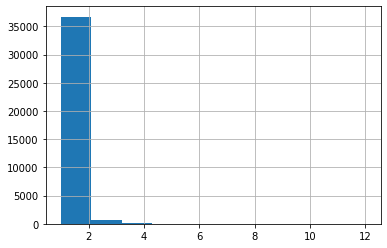

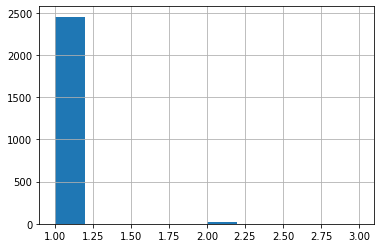

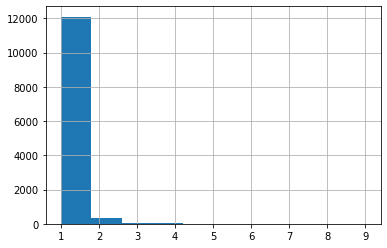

In [6]:
for source in ['vk.com', 'facebook.com', 'youtube.com']:
    total_df[total_df['source']==source]['postId'].value_counts().hist()
    plt.show()

In [16]:
df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed.csv', sep=';')

/home/analyst/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
total_df.drop_duplicates(subset=['postId', 'brands'])['postId'].value_counts()

UgwnlB0RqVzwoSi22HB4AaABAg    9
UgyKfqGECMdCwlVpR5h4AaABAg    8
UgyYrnb3tnn9kqnHEU54AaABAg    8
-193771515_416                7
UgxPX5XoqRK-wOszsrp4AaABAg    7
                             ..
-190996427_1365               1
-165202101_2130586            1
UgwurNdZqTNiA5TdFkl4AaABAg    1
1463029630_173420             1
-52461685_830121              1
Name: postId, Length: 60066, dtype: int64

In [11]:
total_df['brands'] = total_df['brands'].astype(str)

In [22]:
total_df = total_df.drop_duplicates(subset=['postId', 'brands'])

In [42]:
file_m = sorted([f for f in os.listdir('DATA') if brand+'_modeled' in f])[-1]
file_y = sorted([f for f in os.listdir('DATA') if brand+'_youscan' in f])[-1]
upload_to_aws(f'DATA/{file_m}', \
             f'dashboard-table_bsd_{brand}_modeled.csv')
upload_to_aws(f'DATA/{file_y}', \
             f'dashboard-table_bsd_{brand}_youscan.csv')

NameError: name 'upload_to_aws' is not defined